In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
#import pandas as pd
from matplotlib.patches import ArrowStyle
from pathlib import Path

import corneto as cnt
cnt.info()

CORNETO v0.9.1-alpha.0 (up to date)
Available backends:  CVXPY v1.3.0, PICOS v2.4.1
Default backend (corneto.K): CVXPY
Available solvers for CVXPY: CBC, CPLEX, CVXOPT, ECOS, ECOS_BB, GLPK, GLPK_MI, GUROBI, MOSEK, OSQP, SCIP, SCIPY, SCS
https://github.com/saezlab/corneto


## Basic data manipulation

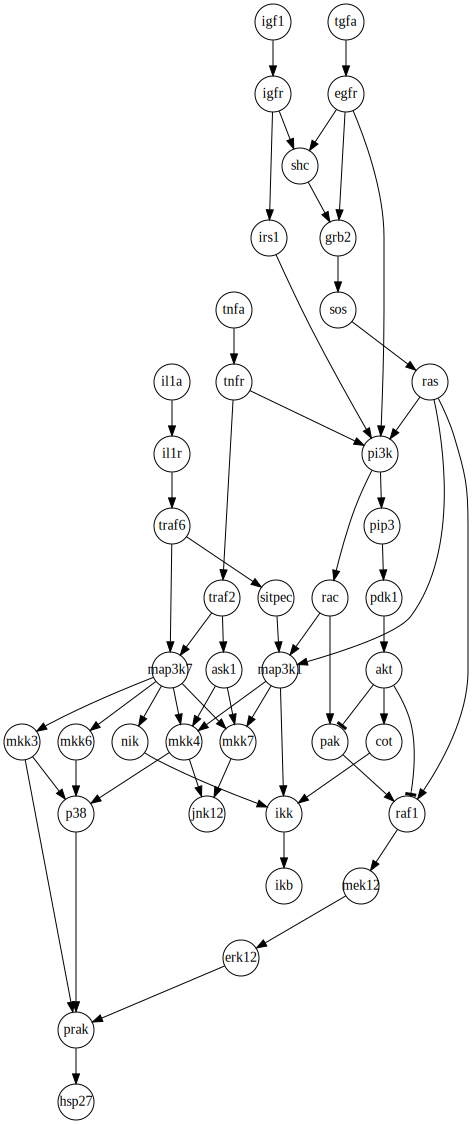

In [2]:
g = cnt.import_sif('../../tests/sif/PKN-LiverDREAM.sif')
g.plot()

In [ ]:
rn._vertex_properties

In [ ]:
g0 = rn.subgraph(['shc', 'grb2'])
g0.plot()

In [ ]:
n0 = rn.select(['akt'])
n0.add_reaction('r1', {'akt': -1, 'puk': 1}, value=-1, inplace=False).plot();

In [ ]:
rn.prune(['tgfa', 'igf1'], ['hsp27']).plot(figsize=(10, 16));

In [ ]:
%%timeit
rn.prune(['tgfa', 'igf1'], ['hsp27'])

In [ ]:
# Create a biochemical network from a dataframe
df_toy = pd.DataFrame({'source':      ['A', 'B', 'B', 'C', 'B', 'D'], 
                       'interaction': [ 1,   1,   1,   1,  -1,   1 ], 
                       'target':      ['B', 'A', 'C', 'B', 'D', 'B']})
rows = [(r.source, r.interaction, r.target) for (i, r) in df_toy.iterrows()]
cnt.ReNet.from_sif(rows).plot();

## CARNIVAL single/multi-condition

In [ ]:
rn = cnt.ReNet.from_sif(rows)
rn.plot();

In [ ]:
# Provisional impl of a more efficient ReNet
# NOTE: ReNet will be rewritten in next versions
from corneto._core import GReNet
rn = GReNet.from_renet(rn)
rn.plot();

In [ ]:
from corneto.methods.signflow import create_flow_graph, signflow

data = {
    'C1': {
        'A': ('P', -5.1),
        'C': ('P', 1.2),
        'D': ('M', 0.5)
    },
    'C2': {
        'A': ('P', 1.1),
        'B': ('P', -0.5),
        'D': ('M', -1.1)
    }
}

# Transform the original network into a carnival network
rne = create_flow_graph(rn, data)
rne.plot(figsize=(10, 10));

In [ ]:
m = signflow(rne, data, l0_penalty_reaction=1e-4, dag=True)

In [ ]:
# Show declared vars in carnival
m.symbols

In [ ]:
# Constraints of carnival
m.constraints

In [ ]:
m.solve(verbosity=1).value

In [ ]:
for i, c in enumerate(data.keys()):
    print(c, "loss:", m._objectives[i].value)

In [ ]:
from corneto.methods.signflow import nx_style
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
rne.plot(custom_style=nx_style(rne, m, condition='C1'), ax=ax[0]);
rne.plot(custom_style=nx_style(rne, m, condition='C2'), ax=ax[1]);

## Filtering and plotting

In [ ]:
# Carnival creates specific variables that can be used to filter the graph.
# _flow_rxn_ipos is a binary variable that indicates if a reaction was preselected
# by carnival for propagating signal
sel_rxn = m.get_symbol('_flow_rxn_ipos').value
rne.select_reactions(np.where(sel_rxn > 0)[0]).plot(custom_style=nx_style(rne, m, condition='C1'), figsize=(6, 10));

In [ ]:
# We can plot also only the part of the network with signal. E.g. for solution C1
sel_rxn = m.get_symbol('reaction_sends_activation_C1').value + m.get_symbol('reaction_sends_inhibition_C1').value
rne.select_reactions(np.where(sel_rxn > 0)[0]).plot(custom_style=nx_style(rne, m, condition='C1'), figsize=(6, 10));